In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [76]:
data = pd.read_csv("~/Desktop/flashcard_/r_files/Admission_math")
data = data.drop(["Unnamed: 0"], axis=1)
data['gre_math'] = data['gre_math'].astype('category')
data['type'] = data['type'].astype('category')
data['research'] = data['research'].astype('category')
data['sex'] = data['sex'].astype('category')
data['major'] = data['major'].astype('category')
data['year'] = data['year'].astype('category')
data.head()

,year,accept_rate,reject_rate,applications,accepted,rejected,gpa,gre_math,gre_quant,gre_verb,gre_awa,type,research,sex,major
0,2010,0.181818,0.818182,11,2,9,0.9650,1,94,95,41,1,1,0,1
1,2010,0.750000,0.250000,4,3,1,0.9725,1,94,97,41,1,1,0,1
2,2010,0.200000,0.800000,10,2,8,0.9925,1,94,96,63,1,1,0,1
3,2010,0.444444,0.555556,9,4,5,1.0000,1,94,88,23,0,1,0,2
4,2010,0.714286,0.285714,7,5,2,0.9300,1,94,77,81,1,0,0,1


# EDA

In [88]:
print(data.describe())
data['major'].value_counts
data[['sex','gre_quant']].groupby('sex').mean()
data[['sex','gre_verb']].groupby('sex').mean()
data[['sex','gre_awa']].groupby('sex').mean()
data.groupby('sex')['sex'].count()
print(data.groupby('gre_math')['gre_math'].count())
print(data.groupby('year')['accept_rate'].describe())
print(data.groupby('major')['accept_rate'].describe())

       accept_rate  reject_rate  applications    accepted    rejected  \
count   536.000000   536.000000    536.000000  536.000000  536.000000   
mean      0.496999     0.503001      8.026119    3.725746    4.300373   
std       0.267163     0.267163      4.003184    2.353238    3.202406   
min       0.000000     0.000000      1.000000    0.000000    0.000000   
25%       0.285714     0.333333      5.000000    2.000000    2.000000   
50%       0.500000     0.500000      8.000000    3.000000    4.000000   
75%       0.666667     0.714286     11.000000    5.000000    6.000000   
max       1.000000     1.000000     21.000000   13.000000   16.000000   

              gpa   gre_quant    gre_verb     gre_awa  
count  536.000000  536.000000  536.000000  536.000000  
mean     0.936122   90.738806   79.686567   62.520522  
std      0.065301    8.270817   18.918781   25.269603  
min      0.500000   47.000000    8.000000    3.000000  
25%      0.902875   88.000000   69.000000   47.000000  
50%   

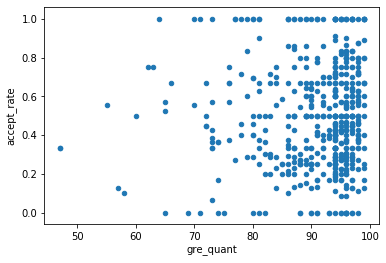

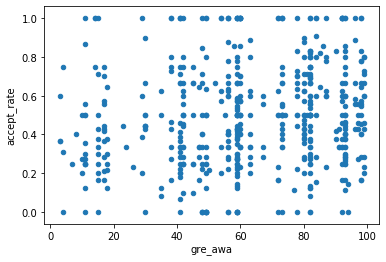

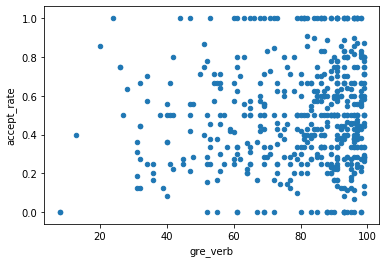

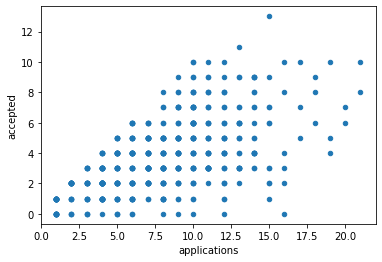

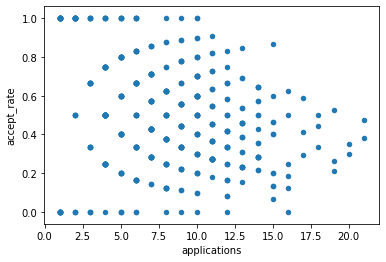

In [75]:
data.plot.scatter(x='gre_quant', y='accept_rate')
data.plot.scatter(x='gre_awa', y='accept_rate')
data.plot.scatter(x='gre_verb', y='accept_rate')
data.plot.scatter(x='applications',y='accepted')
data.plot.scatter(x='applications',y='accept_rate')

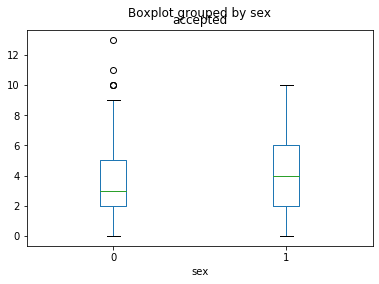

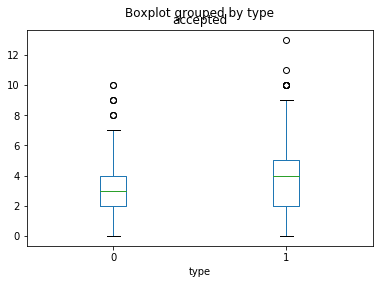

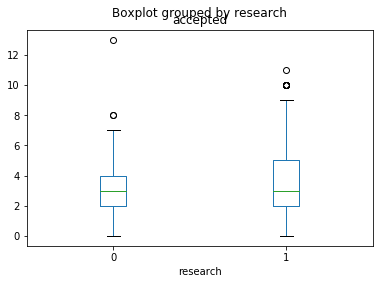

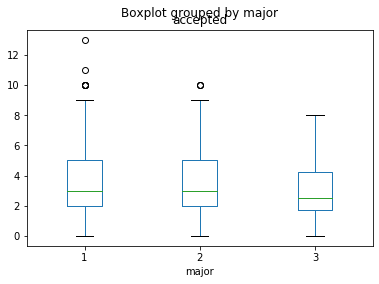

In [87]:
data.boxplot(column='accepted', by='sex', grid=False)
data.boxplot(column='accepted', by='type', grid=False)
data.boxplot(column='accepted', by='research', grid=False)
data.boxplot(column='accepted', by='major', grid=False)

### gre_math detailed EDA

accepted                                              
            count      mean       std  min  25%  50%  75%   max
gre_math                                                       
0           105.0  3.676190  2.399901  0.0  2.0  3.0  5.0  13.0
1           431.0  3.737819  2.344401  0.0  2.0  3.0  5.0  11.0

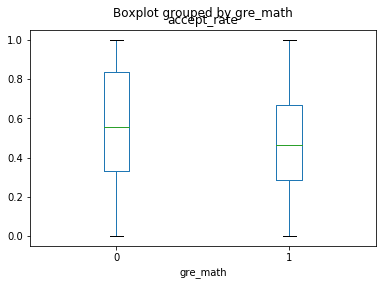

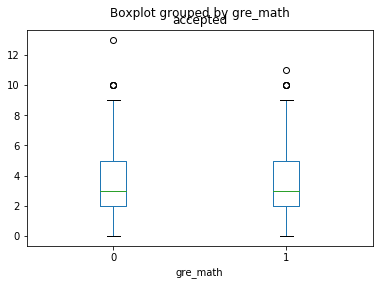

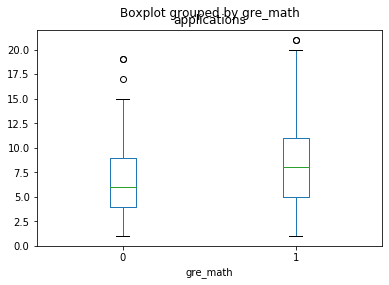

In [72]:
data.boxplot(column='accept_rate', by='gre_math', grid=False)
data.boxplot(column='accepted', by='gre_math', grid=False)
data.boxplot(column='applications', by='gre_math', grid=False)
data[['gre_math','applications']].groupby('gre_math').describe()
data[['gre_math','accepted']].groupby('gre_math').describe()


# Logistic Regression

In [79]:
form = 'accept_rate ~ gpa + gre_math + gre_quant + gre_verb + gre_awa + type + research + sex + major'
log_model = smf.glm(formula=form, data=data, family=sm.families.Binomial(), var_weights=data['applications'])
res = log_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            accept_rate   No. Observations:                  536
Model:                            GLM   Df Residuals:                      525
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2084.4
Date:                Sun, 21 Jun 2020   Deviance:                       933.16
Time:                        11:55:23   Pearson chi2:                     809.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.8467      0.577     -6.663

# Cross-validation


### Wrapper for statsmodel

In [155]:
from sklearn.base import BaseEstimator, RegressorMixin
#from statsmodels.formula.api import glm as glm_sm

class SMFWrapper(BaseEstimator, RegressorMixin):
    """sklearn wrapper for statsmodels"""
    def __init__(self, model_class, formula, family, weights):
        self.model_class = model_class
        self.formula = formula
        self.family = family
        self.weights = weights
        self.model = None
        self.result = None
    def fit(self, X, y):
        self.model = smf.glm(self.formula, data, family=self.family, var_weights=self.weights)
        self.res = self.model.fit()
    def predict(self, X):
        return self.res.predict(X)
    
wrapped = SMFWrapper(model_class=smf.glm, formula=form, family=sm.families.Binomial(), weights=data['applications'])

### Split data into train and test sets 

                 Generalized Linear Model Regression Results                  
Dep. Variable:            accept_rate   No. Observations:                  429
Model:                            GLM   Df Residuals:                      418
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1643.0
Date:                Sun, 21 Jun 2020   Deviance:                       730.12
Time:                        15:15:25   Pearson chi2:                     634.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.8789      0.640     -6.065

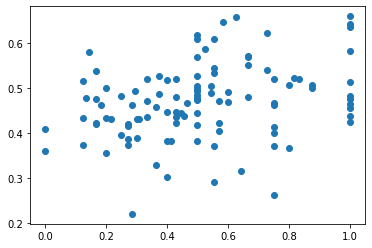

In [119]:
data_train = data.sample(frac=0.8, random_state=3)
data_test = data[~data.index.isin(data_train.index)]

form = 'accept_rate ~ gpa + gre_math + gre_quant + gre_verb + gre_awa + type + research + sex + major'
log_model1 = smf.glm(formula=form, data=data_train, family=sm.families.Binomial(), \
                     var_weights=data_train['applications'])
res1 = log_model1.fit()
print(res1.summary())

pred = res1.predict(data_test)

from matplotlib import pyplot as plt
plt.plot(data_test['accept_rate'],pred, 'o')
MSE = sm.tools.eval_measures.mse(data_test['accept_rate'],pred)
print('MSE:', MSE)

### K-fold CV

In [157]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv_glm = cross_val_score(wrapped, X=data, y=data['accept_rate'], cv=KFold(n_splits=10, random_state=3, shuffle=False))
print("MSE: " + str(np.mean(np.abs(cv_glm ))))

MSE: 0.11644013681448166
